# Summary of Broadcast within a Node

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 20)

project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/intra_anode'
dir_vnode_results = f'{project_dir}/intra_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }
    gpus = [4, 8]

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            for gpu in gpus:
                column_key = f'{method}:{node}:{gpu}'
                file_pattern = f'{dirpath}/job{gpu:02d}.sh.*.{suffix}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode:4,mpi-gpu:anode:8,mpi-gpu:vnode:4,mpi-cpu:anode:4,mpi-cpu:anode:8,mpi-cpu:vnode:4,nccl:anode:4,nccl:anode:8,nccl:vnode:4
1,3.84,5.65,3.61,0.88,1.51,0.84,NaN,NaN,NaN
2,6.13,9.06,5.46,0.74,1.20,0.81,NaN,NaN,NaN
4,6.06,9.06,5.44,0.71,1.16,0.81,7.35,7.78,6.29
8,6.04,9.04,5.47,0.72,1.16,0.82,7.27,7.28,5.24
16,3.79,5.65,4.38,0.70,1.15,0.82,7.28,7.30,5.22
32,5.32,7.36,4.29,0.98,1.46,1.01,7.37,7.31,5.26
64,5.70,7.54,4.46,0.88,1.31,1.09,7.42,7.48,5.24
128,5.81,8.47,4.97,1.08,1.72,1.22,7.36,7.39,5.26
256,5.97,8.56,5.12,1.14,1.83,1.41,7.46,7.49,5.31
512,6.05,8.94,6.57,1.36,1.98,1.53,7.60,7.62,5.27


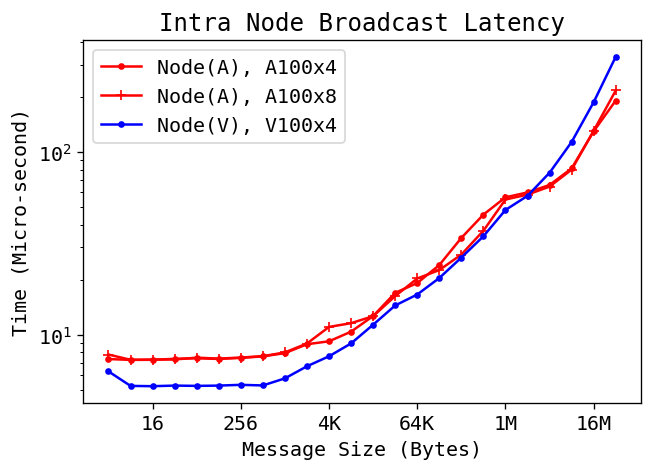

In [4]:
title = 'Intra Node Broadcast Latency'
column_labels = {
    'nccl:anode:4': 'Node(A), A100x4',
    'nccl:anode:8': 'Node(A), A100x8',
    'nccl:vnode:4': 'Node(V), V100x4',
}
markers = ['r.-', 'r+-', 'b.-']
plot(data, column_labels, markers, title)

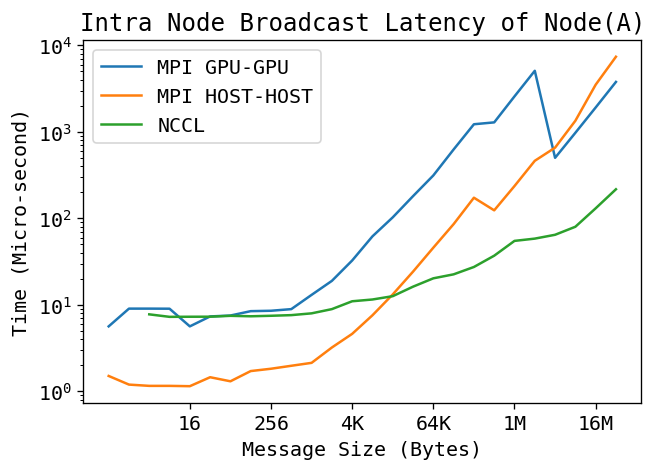

In [5]:
title = 'Intra Node Broadcast Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode:8': 'MPI GPU-GPU',
    'mpi-cpu:anode:8': 'MPI HOST-HOST',
    'nccl:anode:8': 'NCCL',
}
markers = []
plot(data, column_labels, markers, title)

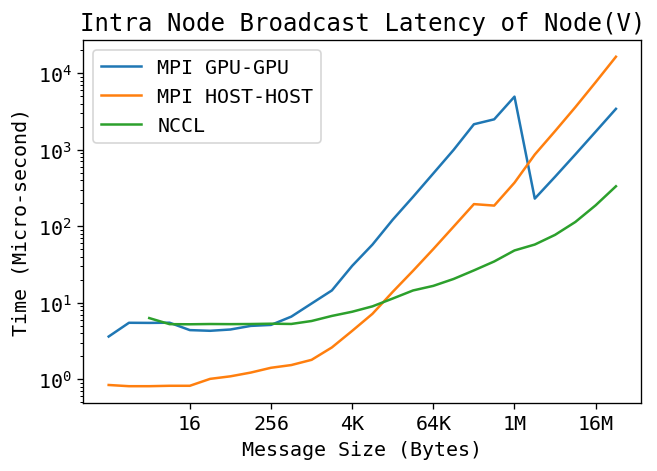

In [6]:
title = 'Intra Node Broadcast Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode:4': 'MPI GPU-GPU',
    'mpi-cpu:vnode:4': 'MPI HOST-HOST',
    'nccl:vnode:4': 'NCCL',
}
markers = []
plot(data, column_labels, markers, title)